## Import libraries

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import cv2
import pickle

import torch
import torch.nn as nn
import torchvision.models as models

import matplotlib.pyplot as plt

import PIL

import gc

If a GPU is available, we want our model to be trained on the GPU

In [3]:
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

The cell below contains all file paths that are going to be used in the training phase

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
images_path = '/content/drive/MyDrive/ML Colab Notebooks/Project_3/Train.pkl'
labels_path = '/content/drive/MyDrive/ML Colab Notebooks/Project_3/Train_labels.csv'

test_images_path = '/content/drive/MyDrive/ML Colab Notebooks/Project_3/Test.pkl'

custom_resnet_50_path = '/content/drive/MyDrive/ML Colab Notebooks/Project_3/crn50.pth'
custom_resnet_50_predictions = '/content/drive/MyDrive/ML Colab Notebooks/Project_3/crn50_pred.csv'

custom_modified_resnet_50_path = '/content/drive/MyDrive/ML Colab Notebooks/Project_3/cmrn50.pth'
custom_modified_resnet_50_predictions = '/content/drive/MyDrive/ML Colab Notebooks/Project_3/cmrn50_pred.csv'

custom_resnet_152_path = '/content/drive/MyDrive/ML Colab Notebooks/Project_3/crn152.pth'
custom_resnet_152_predictions = '/content/drive/MyDrive/ML Colab Notebooks/Project_3/crn152_pred.csv'

custom_modified_resnet_152_path = '/content/drive/MyDrive/ML Colab Notebooks/Project_3/cmrn152.pth'
custom_modified_resnet_152_predictions = '/content/drive/MyDrive/ML Colab Notebooks/Project_3/cmrn152_pred.csv'

## Loading Data

In [7]:
# Load the data
with open(images_path, 'rb') as f:
    images = pickle.load(f)

In [8]:
print(images[0].shape)

(1, 28, 28)


In [9]:
images = np.squeeze(images)

In [10]:
labels_df = pd.read_csv(labels_path)
labels = labels_df['class'].values

In [11]:
with open(test_images_path, 'rb') as f:
    test_images = np.squeeze(pickle.load(f))

## Understanding Data

<function matplotlib.pyplot.show(close=None, block=None)>

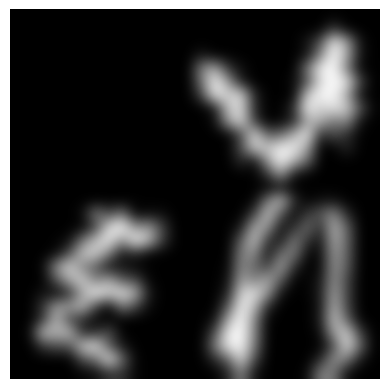

In [ ]:
plt.imshow(images[0], cmap='gray', interpolation='bicubic')
plt.axis('off')
plt.show

### Preparing images for model
Since the model gets an input of images by size (224, 224), we are going to increase the size of the images to be compatible with the input of our model.

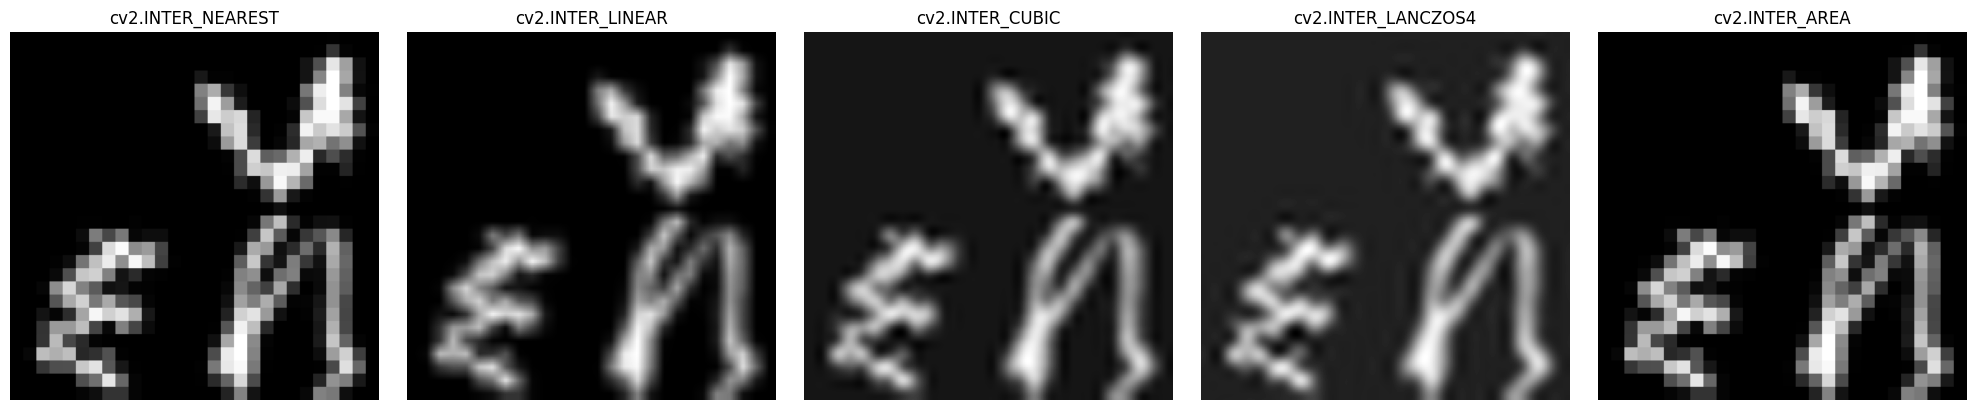

In [ ]:
image = images[0]
interpolations = {cv2.INTER_NEAREST:'cv2.INTER_NEAREST',
                  cv2.INTER_LINEAR:'cv2.INTER_LINEAR',
                  cv2.INTER_CUBIC:'cv2.INTER_CUBIC',
                  cv2.INTER_LANCZOS4:'cv2.INTER_LANCZOS4',
                  cv2.INTER_AREA:'cv2.INTER_AREA'}
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
i = 0
for interpolation in interpolations:
  resized_image = np.array(cv2.resize(image, (224, 224), interpolation=interpolation))
  axs[i].imshow(resized_image, cmap='gray')
  axs[i].set_title(interpolations[interpolation])
  axs[i].axis('off')
  i+=1
plt.tight_layout()
plt.show()

As we can see, the best interpolation overall is `cv2.INTER_LINEAR` interpolation, therefore we chose this for resizing our images

In [12]:
def resize_image(image):
    return cv2.resize(image, (224, 224), interpolation=cv2.INTER_LINEAR)

## Preparing Dataset for Model Learning

### 1. Input Dataset

The function `resize_image` is going to be used to resize the images.
Now there are two approaches depending on the machine that is running the software that we can take:
1. The first approach is to resize the images all at once, a single time, and store them in the RAM. This requires around 24GB of RAM, according to our experiments. But this approach is much faster compared to the next suggestion.
2. The second approach is to resize each image on the fly when the image is getting loaded for training. This not only uses less RAM because the images stored in the RAM are the same (28, 28) size, but it gives us the flexibility of setting the size of each batch according to the amount of VRAM of our GPU.

Since the machine that we are going to run this on is a Google Colab server, and the accessible free tier amount of RAM is only 12.7GB, we are going with the second approach.

In [13]:
class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = resize_image(self.images[idx])
        label = self.labels[idx]
        return torch.tensor(image, dtype=torch.float32).to(device), torch.tensor(label, dtype=torch.long).to(device)

In [14]:
dataset = CustomDataset(images, labels)

### 2. Prediction Dataset

In [15]:
class TestDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = resize_image(self.images[idx])
        return torch.tensor(image, dtype=torch.float32).to(device)

In [16]:
test_dataset = TestDataset(test_images)

## Defining training function

The train_model function is responsible for the tasks below:
1. To get the `model`, `num_epochs`, `data_loader`, `optimizer`, and `criterion` to train the model. Additionally, this function takes a variable called `path_to_previous_training_save`. This path contains a file saved using `torch.save` function, to save the state of the model, epoch, and criterion in case there is a failure to train the model due to environment failure (such as Google Colab disconnecting the resources). The loaded file from the save is called `checkpoint` and it is a dictionary with three keys;
2. To load the `checkpoint` and assign it to the proper variables, if the `checkpoint` exists;
3. To train the model and print the progress;
4. To save a new checkpoint after each epoch.

In [17]:
def train_model(model, num_epochs, data_loader, optimizer, criterion, path_to_previous_training_save):
  # Determine if this model was previously in training
  previous_epochs = 0 # This variable is for resuming from the last epoch that the model was trained at
  try:
    checkpoint = torch.load(path_to_previous_training_save)
    previous_epochs = checkpoint['epoch']
    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optim_state'])
    print(f'A checkpoint was found, starting from epoch: {previous_epochs}')
  except:
    print('A checkpoint in the path did not exist, starting from zero')

  num_epochs -= previous_epochs
  for epoch in range(num_epochs):
    current_epoch_counter = epoch + previous_epochs

    running_loss = 0.0
    for i, (inputs, labels) in enumerate(data_loader):

      inputs = inputs.unsqueeze(1) # Add channel dimension for grayscale images

      optimizer.zero_grad() # Make sure the gradients parameters are zero

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, labels)

      #Backward pass and optimization
      loss.backward()
      optimizer.step()

      # Print statistics every 100 step
      running_loss += loss.item()
      if i % 100 == 0:
          print(f'Epoch [{current_epoch_counter + 1}/{num_epochs+previous_epochs}], Step [{i + 1}/{len(data_loader)}], Loss: {running_loss / 100:.4f}')
          running_loss = 0.0
    new_checkpoint = {
        'epoch': current_epoch_counter + 1,
        'model_state': model.state_dict(),
        'optim_state': optimizer.state_dict()
    }
    torch.save(new_checkpoint, path_to_previous_training_save)

  print('Finished Training')

### Defining evaluating function

The evaluating function input is very similar to the training function, but without the checkpoing saving. Instead of saving a checkpoint, the function will save the predictions in a csv ready to be uploaded on Kaggle

In [18]:
def predict_with_model(model, test_data_loader, path_to_save_predictions):
  model.eval()
  predictions = []
  with torch.no_grad(): # Disable gradient computation for predicting
    for inputs in test_data_loader:
      inputs = inputs.unsqueeze(1)

      outputs = model(inputs)
      _, predicted = torch.max(outputs, 1)
      predictions.extend(predicted.cpu().numpy())

  predictions_df = pd.DataFrame(predictions, columns=['class'])
  predictions_df.reset_index(inplace=True)
  predictions_df.rename(columns={'index': 'id'}, inplace=True)
  predictions_df.to_csv(path_to_save_predictions, index=False)
  print('Finished Predicting')

## Training Models

### Resnet50 with No Modification
This section is to train a resnet50 model with no additional layers.
For this training, we only change the structure of input and output to accomodate our model with our data

In [19]:
class CustomResNet50(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomResNet50, self).__init__()
        # Load a ResNet model
        self.base_model = models.resnet50(weights=None)

        # Replace the first convolutional layer
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        # Replace the fully connected layer
        self.base_model.fc = nn.Linear(in_features=2048, out_features=num_classes)

    def forward(self, x):
        return self.base_model(x)

In [20]:
model = CustomResNet50().to(device)
print(model)

CustomResNet50(
  (base_model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(


In [21]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [22]:
train_model(model, 2, data_loader, optimizer, criterion, custom_resnet_50_path) # Train model

A checkpoint was found, starting from epoch: 2
Finished Training


In [23]:
gc.collect() # To free up RAM as much as possible to prevent crash

12

In [24]:
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [25]:
predict_with_model(model, test_loader, custom_resnet_50_predictions)

Finished Predicting


### Resnet50 with Additional Layers
This section is to train a resnet50 model with new additional layers.
For this training, we add two additional fully connected layers, to reduce the effect of changing from 1000 to 10. Therefor we added two fully connected layers at the end of the model, to reduce the parameters from 100352 when flattened tp 1024, and the other to reduce the parameters from 1024 to 10 to detect our classes.

In [26]:
class CustomResNet50WithAdditionalLayers(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomResNet50WithAdditionalLayers, self).__init__()
        self.base_model = models.resnet50(weights=None)

        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=100352, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=num_classes)

    def forward(self, x):
        x = self.base_model.conv1(x)
        x = self.base_model.bn1(x)
        x = self.base_model.relu(x)
        x = self.base_model.maxpool(x)

        x = self.base_model.layer1(x)
        x = self.base_model.layer2(x)
        x = self.base_model.layer3(x)
        x = self.base_model.layer4(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [27]:
model = CustomResNet50WithAdditionalLayers().to(device)
print(model)

CustomResNet50WithAdditionalLayers(
  (base_model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downs

In [28]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [29]:
train_model(model, 2, data_loader, optimizer, criterion, custom_modified_resnet_50_path) # Train model

A checkpoint was found, starting from epoch: 2
Finished Training


In [30]:
gc.collect() # To free up RAM as much as possible to prevent crash

12

In [31]:
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [32]:
predict_with_model(model, test_loader, custom_modified_resnet_50_predictions)

Finished Predicting


### Resnet152 with No Modification
This section is to train a resnet152 model with no additional layers.
For this training, we only change the structure of input and output to accomodate our model with our data

In [33]:
class CustomResNet152(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomResNet152, self).__init__()
        # Load a ResNet152 model
        self.base_model = models.resnet152(weights=None)

        # Replace the first convolutional layer
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        # Replace the fully connected layer
        self.base_model.fc = nn.Linear(in_features=2048, out_features=num_classes)

    def forward(self, x):
        return self.base_model(x)

In [34]:
model = CustomResNet152().to(device)
print(model)

CustomResNet152(
  (base_model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

In [35]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [36]:
train_model(model, 1, data_loader, optimizer, criterion, custom_resnet_152_path) # Train model

A checkpoint in the path did not exist, starting from zero
Epoch [1/1], Step [1/938], Loss: 0.0260
Epoch [1/1], Step [101/938], Loss: 2.3814
Epoch [1/1], Step [201/938], Loss: 2.0468
Epoch [1/1], Step [301/938], Loss: 1.5476
Epoch [1/1], Step [401/938], Loss: 1.1476
Epoch [1/1], Step [501/938], Loss: 0.8524
Epoch [1/1], Step [601/938], Loss: 0.6885
Epoch [1/1], Step [701/938], Loss: 0.5833
Epoch [1/1], Step [801/938], Loss: 0.5252
Epoch [1/1], Step [901/938], Loss: 0.4385
Finished Training


In [37]:
gc.collect() # To free up RAM as much as possible to prevent crash

0

In [38]:
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [39]:
predict_with_model(model, test_loader, custom_resnet_152_predictions)

Finished Predicting


### Resnet152 with Additional Layers
This section is to train a resnet152 model with new additional layers.
For this training, we add two additional fully connected layers, to reduce the effect of changing from 1000 to 10. Therefor we added two fully connected layers at the end of the model, to reduce the parameters from 100352 when flattened tp 1024, and the other to reduce the parameters from 1024 to 10 to detect our classes.

In [40]:
class CustomResNet152WithAdditionalLayers(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomResNet152WithAdditionalLayers, self).__init__()
        # Load a ResNet152 model
        self.base_model = models.resnet152(weights=None)

        # Replace the first convolutional layer
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        # Additional layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=100352, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=num_classes)

    def forward(self, x):
        x = self.base_model.conv1(x)
        x = self.base_model.bn1(x)
        x = self.base_model.relu(x)
        x = self.base_model.maxpool(x)

        x = self.base_model.layer1(x)
        x = self.base_model.layer2(x)
        x = self.base_model.layer3(x)
        x = self.base_model.layer4(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [41]:
model = CustomResNet152WithAdditionalLayers().to(device)
print(model)

CustomResNet152WithAdditionalLayers(
  (base_model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (down

In [42]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [43]:
train_model(model, 1, data_loader, optimizer, criterion, custom_modified_resnet_152_path) # Train model

A checkpoint in the path did not exist, starting from zero
Epoch [1/1], Step [1/938], Loss: 0.0236
Epoch [1/1], Step [101/938], Loss: 32.8501
Epoch [1/1], Step [201/938], Loss: 8.2431
Epoch [1/1], Step [301/938], Loss: 2.8878
Epoch [1/1], Step [401/938], Loss: 2.2619
Epoch [1/1], Step [501/938], Loss: 2.0686
Epoch [1/1], Step [601/938], Loss: 1.8436
Epoch [1/1], Step [701/938], Loss: 1.6252
Epoch [1/1], Step [801/938], Loss: 1.4008
Epoch [1/1], Step [901/938], Loss: 1.2460
Finished Training


In [44]:
gc.collect() # To free up RAM as much as possible to prevent crash

0

In [45]:
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [46]:
predict_with_model(model, test_loader, custom_modified_resnet_152_predictions)

Finished Predicting
